<a href="https://colab.research.google.com/github/ishaqmarashy/Digit-Recognizer-ML/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Common imports
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Import Kaggle Data https://www.kaggle.com/competitions/digit-recognizer/overview
# From CSV to Pandas DataFrame
train = pd.read_csv( "./train.csv")
test = pd.read_csv("./test.csv")

In [36]:
# Print a labels and some of the samples to see what the dataset looks like and how many samples we are working with
print(train.info(),train.columns,"\n",train['label'].value_counts(),"\n",train['pixel0']) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785) 
 1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64 
 0        0
1        0
2        0
3        0
4        0
        ..
41995    0
41996    0
41997    0
41998    0
41999    0
Name: pixel0, Length: 42000, dtype: int64


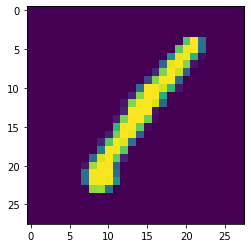

In [37]:
# Converts class vectors to binary class matrix
# more at https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
from keras.utils.np_utils import to_categorical 

# The label column contains the images identity which we would like to predict
# So we seperate it and place it in y to train our model later
y = to_categorical(train['label'], num_classes = 10)
# Removing the label data leaves us with the pixel information. 
X = train.drop('label',axis=1)
# There are 784 columns(1D) thus the images need to be reshaped into 28x28(2D) Data 
X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
plt.imshow(X[0][:,:,0])

In [38]:
# z = (x – μ) / σ apply z-score normalization for faster learning
mu = X.mean().astype(np.float32)
std = X.std().astype(np.float32)
X=(X-mu)/std
test=(test-mu)/std

In [39]:
from sklearn.model_selection import train_test_split
# Split our data into a training section and a seperate validation section to insure we can check for accuracy
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
# Build a neural network model to make predictions
model = Sequential([
        # Conv2d is a convolutional neural network(CNN) layer
        # stride is the sliding window for each dimension of input 
        # https://keras.io/api/layers/convolution_layers/convolution2d/
        # neuron count, kernal size
        Conv2D(28,(3,3), activation='relu',input_shape=(28,28,1)),
        # Normalize the output of the Conv2d layer above for faster training
        # https://keras.io/api/layers/normalization_layers/batch_normalization/
        BatchNormalization(),
        Conv2D(28,(6,6), activation='relu'),
        # Pools the outputs of previous layer
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
        MaxPool2D(),
        # flattens the tensor output of the previous layer into a 1 dimentional tensor
        # https://pytorch.org/docs/stable/generated/torch.flatten.html
        Flatten(),
        Dense(512, activation='relu'),
        # 10 specified the neuron count which should be equal to the number of labels we have
        # softmax is a common activation function used for multi-classification problems
        Dense(10, activation='softmax')
        ])
# Adam implements a variable learning rate among other features that speed up convergence
# categorical_crossentropy is the partial derivative of the softmax function which creates a single global minima for the gradient to converge on
# accuracy is the metric we would like to see throught he epocs cycle
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#AdThrive_Content_1_desktop
model.compile(Adam(), loss='categorical_crossentropy',metrics=['accuracy'])

In [41]:
from keras.preprocessing.image import ImageDataGenerator

# Creates additional images for the model to train on by using data augmentation techniques
datagen = ImageDataGenerator(
    # Center images so its padding is equal from all sides
    featurewise_center=True,
    samplewise_center=False, 
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    # Rotate images randomly by 20%
    rotation_range=20,
    # Shift images randomly by 10% shrinking or stretching vertically and horizontally
    width_shift_range=0.1,
    height_shift_range=0.1,
    # Shift images randomly by 10% shrinking or stretching vertically and horizontally
    horizontal_flip=False,  
    vertical_flip=False)
# Feed data into the data generator so it may create augmented data for us
datagen.fit(X_train)
# Number of iterations of the the dataset
epochs=30
batch_size = 32
# Finally generate images fromt he traing examples from the learned augmentation techniques
train_data=datagen.flow(X_train,y_train, batch_size=batch_size)
validation_data=datagen.flow(X_train, y_train, batch_size=8)
# Train the model using the expanded dataset 
histcb=model.fit(train_data, validation_data=validation_data,verbose = 2,steps_per_epoch=len(X_train) / batch_size, epochs=epochs)

Epoch 1/30
918/918 - 201s - loss: 0.3547 - accuracy: 0.8929 - val_loss: 0.1507 - val_accuracy: 0.9503 - 201s/epoch - 219ms/step
Epoch 2/30
918/918 - 225s - loss: 0.1272 - accuracy: 0.9597 - val_loss: 0.0905 - val_accuracy: 0.9723 - 225s/epoch - 245ms/step
Epoch 3/30
918/918 - 182s - loss: 0.0995 - accuracy: 0.9698 - val_loss: 0.1014 - val_accuracy: 0.9688 - 182s/epoch - 198ms/step
Epoch 4/30
918/918 - 182s - loss: 0.0894 - accuracy: 0.9735 - val_loss: 0.0801 - val_accuracy: 0.9749 - 182s/epoch - 198ms/step
Epoch 5/30
918/918 - 186s - loss: 0.0844 - accuracy: 0.9744 - val_loss: 0.0683 - val_accuracy: 0.9788 - 186s/epoch - 202ms/step
Epoch 6/30
918/918 - 183s - loss: 0.0718 - accuracy: 0.9789 - val_loss: 0.0694 - val_accuracy: 0.9797 - 183s/epoch - 199ms/step
Epoch 7/30
918/918 - 182s - loss: 0.0755 - accuracy: 0.9765 - val_loss: 0.0808 - val_accuracy: 0.9765 - 182s/epoch - 198ms/step
Epoch 8/30
918/918 - 181s - loss: 0.0663 - accuracy: 0.9803 - val_loss: 0.0655 - val_accuracy: 0.9800 - 

In [42]:
# Make predictions as to what the label of the image may be
y_pred=model.predict( X_train, batch_size=batch_size, verbose=0)
# Take probability of those predictions and pick the most probable label using argmax
y_pred=np.argmax(y_pred,axis = 1) 
y_pred

array([4, 0, 9, ..., 2, 6, 0])